# Import graph

In [71]:
import igraph as ig
import coarse
import random

from data.graph_generator import *


nData = 100
nTasks = 45
edgeProb = 0.10


outgoingEdges = 2

avgDataDep = 4
stddDataDep = 3

g = generate_realistic(nData, nTasks, avgDataDep, stddDataDep)

# g = generate_graph(nData, nTasks, edgeProb)

# g = generate_barabasi(nData + nTasks, outgoingEdges)
# from data.testgraph3 import *

### Eliminate isolated vertices

In [72]:
toDelete = []
for v in g.vs:
    if not v.neighbors():
        toDelete.append(v)
g.delete_vertices(toDelete)

## Plot the graph, define layout and visual style

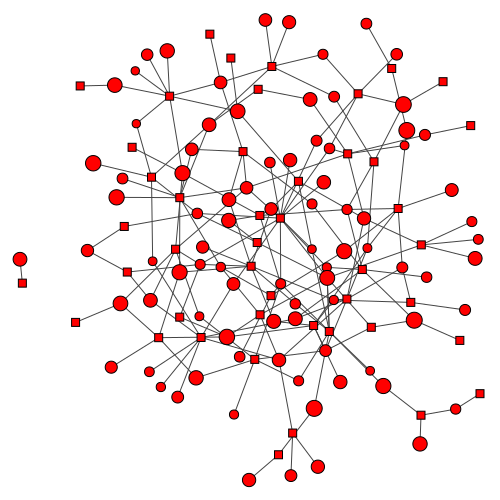

In [73]:
volumes = g.vs["volume"]
maxVolume = max(volumes)

nVertices = len(g.vs)
nEdges = len(g.es)

visual_style = {}

layout = g.layout("fr")
visual_style["layout"] = layout

# g.vs["label"] = g.vs["name"]
# visual_style["vertex_label"] = g.vs["name"]
visual_style["vertex_size"] = [8 * (1 + volumes[i]/maxVolume) for i in range(nVertices)]
visual_style["bbox"] = (500, 500)
visual_style["margin"] = 20
visual_style["vertex_shape"] = ["circle" if g.vs[i]["name"][0] == 'd' else "square" for i in range(nVertices)]

# print("Vertex names:")
# print(["{0}: {1}".format(i, g.vs[i]["name"]) for i in range(len(g.vs))])
# print("\nWeighted edges")
# for e in g.es:
#     print("{0} -- {1}: {2}".format(g.vs[e.source]["name"], g.vs[e.target]["name"], e["weight"]))

ig.plot(g, **visual_style)

## Cluster cost parameters

Generate a random set of clusters

In [74]:
import numpy as np

nClusters = 2
clusters = range(nClusters)


costexp = 30
coststdd = 30

cost = [[0 for c1 in range(nClusters)] for c2 in range(nClusters)]
for c1 in range(nClusters):
    for c2 in range(c1+1, nClusters):
        cost[c1][c2] = max(round(random.gauss(costexp, coststdd),2),2.)
        cost[c2][c1] = cost[c1][c2]
cost = np.array(cost)

# cost = np.array([[0., 1.], [1.,0.]])

print(cost)

[[ 0.   83.19]
 [83.19  0.  ]]


## Coarsening the graph
The graph is coarsened until its number of vertices is less than a specified number.

In [75]:
import coarse

vertexLimit = 20
graphs = [g]

while len(graphs[-1].vs) > vertexLimit:
    coarserGraph = coarse.coarsen(graphs[-1])
    graphs.append(coarserGraph)

print(graphs[-1].vs["volume"])

[3.1599999999999997, 0.68, 5.279999999999999, 1.52, 2.42, 0.31, 0.47, 0.57, 3.3199999999999994, 5.47, 0.14, 5.0, 2.96, 4.5600000000000005, 0.04, 3.02, 3.94, 0.71]


6


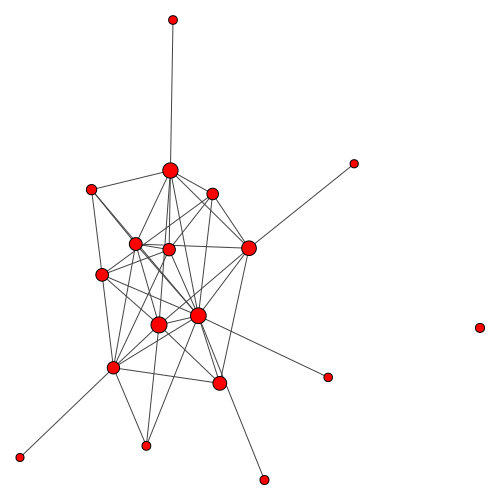

In [76]:
cg = graphs[-1]

volumes = cg.vs["volume"]
maxVolume = max(volumes)

nVertices = len(cg.vs)
vertices = range(nVertices)
nEdges = len(cg.es)

visual_style = {}
layout = cg.layout("fr")
visual_style["layout"] = layout
# cg.vs["label"] = cg.vs["name"]
# visual_style["vertex_label"] = cg.vs["name"]
visual_style["vertex_size"] = [8 * (1 + volumes[i]/maxVolume) for i in range(nVertices)]
visual_style["bbox"] = (500, 500)
visual_style["margin"] = 20


# print("Vertex names:")
# print(["{0}: {1}".format(i, cg.vs[i]["name"]) for i in range(len(cg.vs))])
# print("\nWeighted edges")
# for e in cg.es:
#     print("{0} -- {1}: {2}".format(cg.vs[e.source]["name"], cg.vs[e.target]["name"], e["weight"]))

print(len(graphs))
ig.plot(cg, **visual_style)

# Calculate the initial partition on the coarsest graph, using a LP

In [77]:
from LP import partitionLP
import refining as ref

cg = graphs[-1]
color_dict_vertex = {0: "blue", 1: "red", 2: "green", 3: "pink", 4: "orange" }
tolerance = 0.1

(placement, visual_style) = partitionLP(cost, nClusters, cg, tolerance, color_dict_vertex)

print("Verifying total cost: " + str(ref.edgeCut(cg, placement, cost, nClusters)))

Number of variables = 204
Number of constraints = 524
Optimal objective value = 828

Placement:
Total cost: 828.5724000000002
Verifying total cost: 828.5724000000002


In [78]:
print("Verifying total cost: " + str(ref.edgeCut(cg, placement, cost, nClusters)))


Verifying total cost: 828.5724000000002


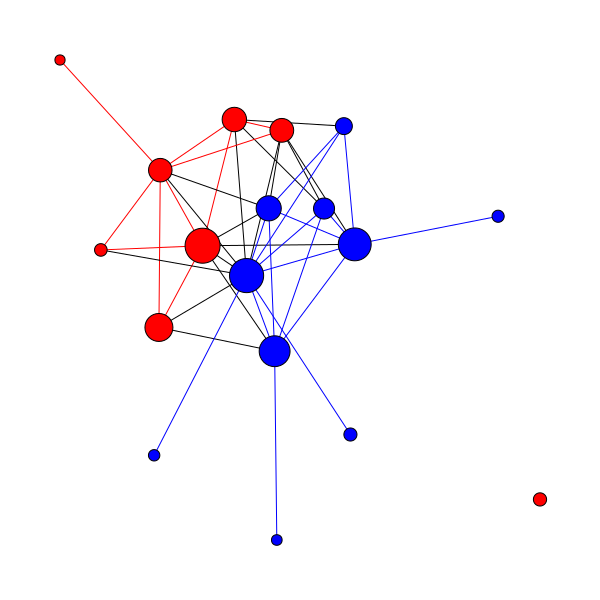

In [79]:
visual_style["vertex_size"] = 30
visual_style["bbox"] = (600, 600)
visual_style["margin"] = 60

volumes = cg.vs["volume"]
maxVolume = max(volumes)
visual_style["vertex_size"] = [10 + volumes[i]*50/(2*maxVolume) for i in range(len(cg.vs))]

cg = graphs[-1]
ig.plot(cg, "initial_partition.png", **visual_style)

# for edge in cg.es:
#     if placement[edge.source] != placement[edge.target]:
#         print("({0}, {2}) -- ({1}, {3}): {4}".format(edge.source, edge.target, placement[edge.source], placement[edge.target], edge["weight"]))

# Uncoarsen the graph and propagate the initial partition
We run the Kernighan-Lin algorithm at each uncoarsening.

In [80]:
import refining as ref

partitions = [placement]
partCosts = []
for i in range(len(graphs)-1, 0, -1):
    commCost = 0
    fg = graphs[i-1]
    cg = graphs[i]
    newPart = coarse.uncoarsen(cg, fg, partitions[0])
    #### TODO: newPart = K-L(fg, newPart)
    volumes = fg.vs["volume"]
    maxVolume = max(volumes)
    loadPerCluster = sum(volumes) * (1+tolerance) / nClusters
    loadLimits = [loadPerCluster for i in range(nClusters)]
    newPart = ref.K_L(fg, newPart, nClusters, cost, loadLimits)
    partitions.insert(0, newPart)
    
    cutEdges = []
    for e in fg.es:
        if newPart[e.source] != newPart[e.target]:
            cutEdges.append(True)
            commCost += fg.es[e.index]["weight"] * cost[newPart[e.source], newPart[e.target]]
        else:
            cutEdges.append(False)
    
    
    visual_style = {}
    color_dict_vertex = {0: "blue", 1: "red", 2: "green", 3: "pink", 4: "orange" }
    visual_style["vertex_size"] = [8 * (1 + volumes[i]/maxVolume) for i in range(len(fg.vs))]
    visual_style["vertex_color"] = [color_dict_vertex[newPart[v]] for v in range(len(fg.vs))]
    visual_style["edge_color"] = ["black" if cutEdges[edg] else color_dict_vertex[newPart[fg.es[edg].source]] for edg in range(len(fg.es))]
    if i == 1:
        visual_style["vertex_shape"] = ["circle" if fg.vs[v]["name"][0] == 'd' else "square" for v in range(len(fg.vs))]
    ig.plot(fg, "partition%s.png" % i, **visual_style)
    
    partCosts.insert(0, commCost)


# Display final partition and cost

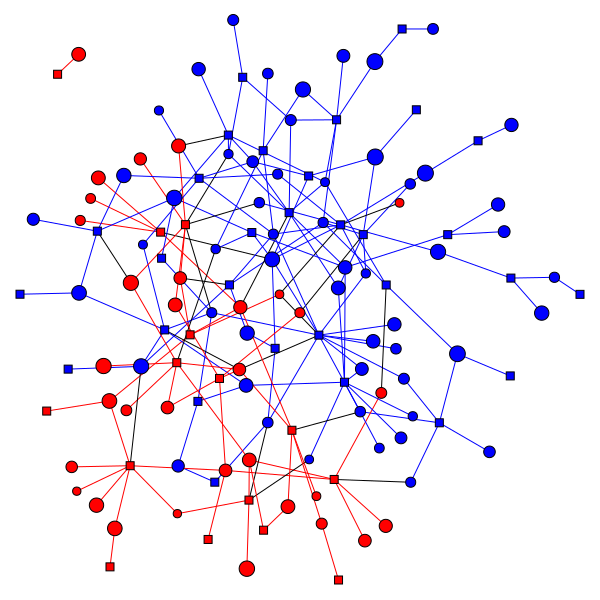

In [81]:
from IPython.display import Image
Image("partition1.png")



In [82]:
print(partCosts)

[695.4684, 742.0548, 742.0548000000001, 742.0548, 742.0547999999999]


In [83]:
g0 = graphs[0]
p0 = partitions[0]
volumes = g0.vs["volume"]
loadPerCluster = sum(volumes) * (1+tolerance) / nClusters
loadLimits = [loadPerCluster for i in range(nClusters)]
print(loadLimits)

availSpace = ref.freeSpace(g0, p0, loadLimits)
print(availSpace)

[23.963500000000007, 23.963500000000007]
[-3.0264999999999973, 7.383500000000012]


## Random Partition then refining with K_L

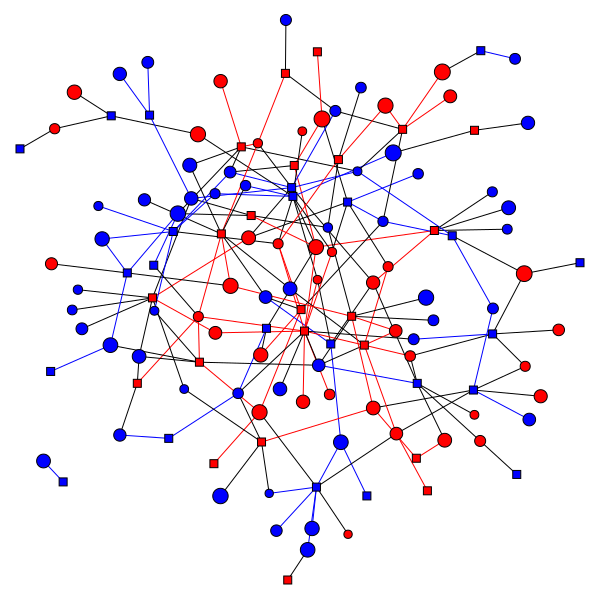

In [87]:
randomPart = [random.randint(0, nClusters-1) for i in range(len(g.vs))]

color_dict_vertex = {0: "blue", 1: "red", 2: "green", 3: "pink", 4: "orange" }
cutEdges = []
cutValue = 0
for e in g.es:
    if randomPart[e.source] != randomPart[e.target]:
        cutEdges.append(True)
        cutValue += g.es[e.index]["weight"] * cost[randomPart[e.source], randomPart[e.target]]
    else:
        cutEdges.append(False)
visual_style["vertex_color"] = [color_dict_vertex[randomPart[v]] for v in range(len(g.vs))]
visual_style["edge_color"] = ["black" if cutEdges[edg] else color_dict_vertex[randomPart[g.es[edg].source]] for edg in range(len(g.es))]
ig.plot(g, **visual_style)


In [88]:
print("Cut value: " + str(cutValue))

Cut value: 4096.275599999998


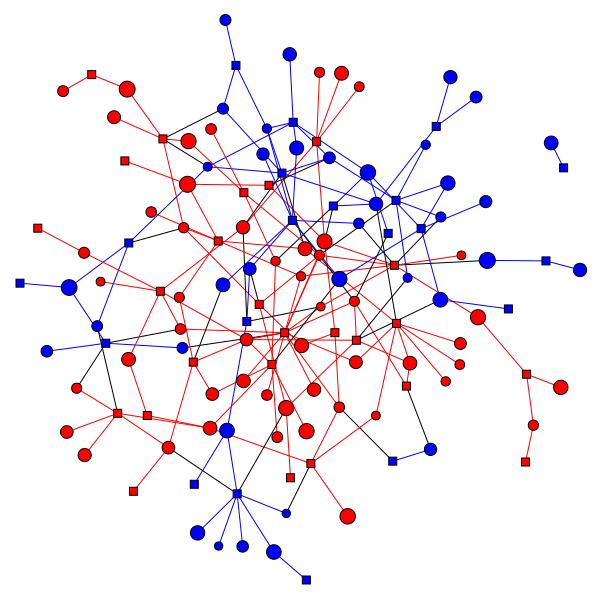

In [89]:
refinedPart = ref.K_L(g, randomPart, nClusters, cost, loadLimits)
cutEdges = []
cutValue = 0
for e in g.es:
    if refinedPart[e.source] != refinedPart[e.target]:
        cutEdges.append(True)
        cutValue += g.es[e.index]["weight"] * cost[refinedPart[e.source], refinedPart[e.target]]
    else:
        cutEdges.append(False)
visual_style["vertex_color"] = [color_dict_vertex[refinedPart[v]] for v in range(len(g.vs))]
visual_style["edge_color"] = ["black" if cutEdges[edg] else color_dict_vertex[refinedPart[g.es[edg].source]] for edg in range(len(g.es))]
ig.plot(g, **visual_style)


In [91]:
print("Refined cut value: " + str(cutValue))
print(2**2000)

Refined cut value: 1161.3323999999998
114813069527425452423283320117768198402231770208869520047764273682576626139237031385665948631650626991844596463898746277344711896086305533142593135616665318539129989145312280000688779148240044871428926990063486244781615463646388363947317026040466353970904996558162398808944629605623311649536164221970332681344168908984458505602379484807914058900934776500429002716706625830522008132236281291761267883317206598995396418127021779858404042159853183251540889433902091920554957783589672039160081957216630582755380425583726015528348786419432054508915275783882625175435528800822842770817965453762184851149029376
